In [1]:
# !pip install git+https://github.com/huggingface/transformers

In [2]:
from transformers import Sam3Processor, Sam3Model
import torch
from PIL import Image
import requests

# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps"

model = Sam3Model.from_pretrained("facebook/sam3").to(device)
processor = Sam3Processor.from_pretrained("facebook/sam3")

# Load image
image_url = "/Users/ljoana/repos/LLMs-Journey/images/bl_cat.png"
# image_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg"
# image = Image.open(requests.get(image_url, stream=True).raw).convert("RGB")
image = Image.open(image_url).convert("RGB")

# Segment using text prompt
inputs = processor(images=image, text="cat", return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)

# Post-process results
results = processor.post_process_instance_segmentation(
    outputs,
    threshold=0.5,
    mask_threshold=0.5,
    target_sizes=inputs.get("original_sizes").tolist()
)[0]

print(f"Found {len(results['masks'])} objects")
# Results contain:
# - masks: Binary masks resized to original image size
# - boxes: Bounding boxes in absolute pixel coordinates (xyxy format)
# - scores: Confidence scores


Loading weights:   0%|          | 0/1468 [00:00<?, ?it/s]

Found 1 objects


In [3]:
import numpy as np
import matplotlib

def overlay_masks(image, masks):
    image = image.convert("RGBA")
    masks = 255 * masks.cpu().numpy().astype(np.uint8)
    
    n_masks = masks.shape[0]
    cmap = matplotlib.colormaps.get_cmap("rainbow").resampled(n_masks)
    colors = [
        tuple(int(c * 255) for c in cmap(i)[:3])
        for i in range(n_masks)
    ]

    for mask, color in zip(masks, colors):
        mask = Image.fromarray(mask)
        overlay = Image.new("RGBA", image.size, color + (0,))
        alpha = mask.point(lambda v: int(v * 0.5))
        overlay.putalpha(alpha)
        image = Image.alpha_composite(image, overlay)
    return image


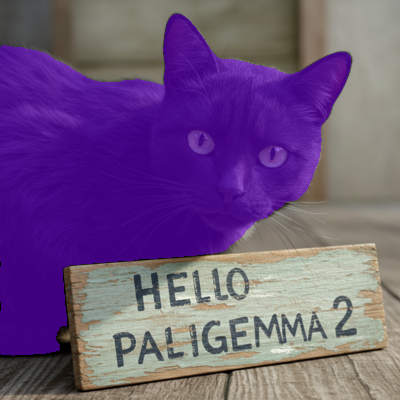

In [4]:
overlay_masks(image, results["masks"])

In [5]:
from transformers import Sam3TrackerProcessor, Sam3TrackerModel
from accelerate import Accelerator
import torch
from PIL import Image
import requests

device = Accelerator().device

model = Sam3TrackerModel.from_pretrained("facebook/sam3").to(device)
processor = Sam3TrackerProcessor.from_pretrained("facebook/sam3")

image_url = "https://huggingface.co/datasets/hf-internal-testing/sam2-fixtures/resolve/main/truck.jpg"
raw_image = Image.open(requests.get(image_url, stream=True).raw).convert("RGB")

input_points = [[[[500, 375]]]]  # Single point click, 4 dimensions (image_dim, object_dim, point_per_object_dim, coordinates)
input_labels = [[[1]]]  # 1 for positive click, 0 for negative click, 3 dimensions (image_dim, object_dim, point_label)

inputs = processor(images=raw_image, input_points=input_points, input_labels=input_labels, return_tensors="pt").to(model.device)

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"])[0]

# The model outputs multiple mask predictions ranked by quality score
print(f"Generated {masks.shape[1]} masks with shape {masks.shape}")


You are using a model of type sam3_video to instantiate a model of type sam3_tracker. This is not supported for all configurations of models and can yield errors.


Loading weights:   0%|          | 0/685 [00:00<?, ?it/s]

Generated 3 masks with shape torch.Size([1, 3, 1200, 1800])


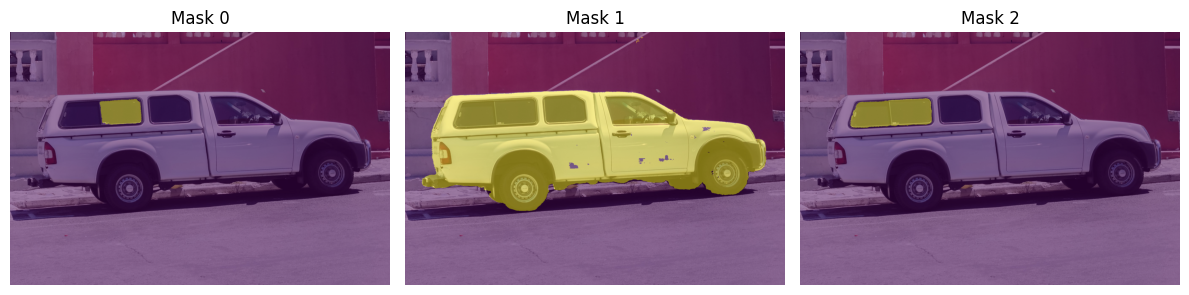

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize all mask proposals overlayed on the image
image_np = np.array(raw_image)
masks_np = masks.detach().cpu().numpy() if hasattr(masks, 'detach') else np.asarray(masks)

if masks_np.ndim == 4:
    # (objects, masks, H, W) -> flatten objects
    masks_np = masks_np.reshape(-1, *masks_np.shape[-2:])
elif masks_np.ndim == 2:
    masks_np = masks_np[None, ...]

num_masks = masks_np.shape[0]
cols = min(3, num_masks)
rows = int(np.ceil(num_masks / cols))
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))

if num_masks == 1:
    axes = [axes]
else:
    axes = axes.ravel()

for i in range(num_masks):
    ax = axes[i]
    ax.imshow(image_np)
    ax.imshow(masks_np[i], cmap='viridis', alpha=0.5)
    ax.set_title(f'Mask {i}')
    ax.axis('off')

for j in range(num_masks, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()
